In [1]:
from matplotlib.pyplot import imshow
from PIL import Image
import librosa
import soundfile
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Input
from keras.models import Model
%matplotlib inline

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
img_size = 512

In [5]:
def wav_to_mel(file_path):
  y, sr = librosa.load(file_path)
  audio, _ = librosa.effects.trim(y)
  n_fft=2048
  hop_length=512
  n_mels=128
  S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=n_fft, 
                                  hop_length=hop_length, n_mels=n_mels)
  im =Image.fromarray(S).convert('F') 
  im.show()
  output_path = file_path.split('.')[0]+'.tiff'
  im.save(file_path.split('.')[0]+'.tiff')
  return output_path, sr

In [6]:
def mel_to_wav(file_path, sr):
  im=Image.open(file_path) 
  img=np.array(im)
  n_fft=2048
  hop_length=512
  n_mels=128
  wav=librosa.feature.inverse.mel_to_audio(img, sr=sr, n_fft=n_fft, hop_length=hop_length)
  print(img)
  soundfile.write(file_path.split('.')[0]+'_ext.wav',wav,samplerate=sr)

In [7]:
content_mel__path, content_sampeling_rate = wav_to_mel("/content/drive/MyDrive/CS308/input_file/classical00000.wav")
style_mel_path, style_sampeling_rate = wav_to_mel("/content/drive/MyDrive/CS308/input_file/jazz00000.wav")

In [8]:
content_image = np.array(Image.open(content_mel__path))
content_image = np.expand_dims(content_image, axis=-1)
input_shape = content_image.shape
print(content_image.shape)
content_image = tf.constant(np.reshape(content_image , ((1, ) + content_image.shape)))
print(content_image.shape)

(128, 1293, 1)
(1, 128, 1293, 1)


In [9]:
style_image = np.array(Image.open(style_mel_path))
style_image = np.expand_dims(style_image, axis=-1)
print(style_image.shape)
style_image = tf.constant(np.reshape(style_image, ((1, ) + style_image.shape)))
print(style_image.shape)

(128, 1293, 1)
(1, 128, 1293, 1)


In [10]:
input_shape = input_shape

conv_model = Sequential()
conv_model.add(Input(shape=input_shape))
conv_model.add(Conv1D(256, 4, activation='relu', input_shape=input_shape[1:]))
conv_model.add(Conv1D(128, 4, activation='relu', input_shape=input_shape[1:]))

conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 1290, 256)    1280      
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 1287, 128)    131200    
                                                                 
Total params: 132,480
Trainable params: 132,480
Non-trainable params: 0
_________________________________________________________________


In [11]:
def compute_content_cost(content_output, generated_output):
    #Here to calculate content cost we just need the output of final layer of the model.
    #The final layer of the model can be considered as an embedding of the input image
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    #Unrolling a_C and a_G for calculating content loss
    a_C_unrolled = tf.reshape(tf.transpose(a_C, perm=[0, 3, 1, 2]), shape=[n_C, -1])
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm=[0, 3, 1, 2]), shape=[n_C, -1])
    
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

In [12]:
def gram_matrix(A):
    GA = tf.linalg.matmul(A, tf.transpose(A))
    return GA

In [13]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(tf.transpose(a_S, perm=[0, 3, 1, 2]), shape=[n_C, -1])
    a_G = tf.reshape(tf.transpose(a_G, perm=[0, 3, 1, 2]), shape=[n_C, -1])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1. / (4 * (n_C**2) * (n_H * n_W)**2) )*tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
        
    return J_style_layer

In [14]:
for layer in conv_model.layers:
    print(layer.name)

conv1d
conv1d_1


In [15]:
STYLE_LAYERS = [
    ('conv1d', 0.5),
    ('conv1d_1', 0.5)
]

In [16]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [17]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style

    return J

In [18]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)

(1, 128, 1293, 1)


In [19]:
model = Model(inputs=conv_model.input,
              outputs=[conv_model.get_layer(layer_name).output for layer_name in ['conv1d', 'conv1d_1']])

In [20]:
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = model(preprocessed_content) #Getting outputs of the selected layer for content image

In [21]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = model(preprocessed_style) #Getting outputs of the selected layer for content image

In [22]:
preprocessed_content

<tf.Variable 'Variable:0' shape=(1, 128, 1293, 1) dtype=float32, numpy=
array([[[[6.7832910e-02],
         [8.1732556e-02],
         [9.2335865e-02],
         ...,
         [1.9207202e-02],
         [5.1326319e-03],
         [2.4790004e-02]],

        [[5.6347364e-01],
         [5.4257089e-01],
         [8.2370865e-01],
         ...,
         [8.6506766e-01],
         [5.3224003e-01],
         [4.4475153e-01]],

        [[8.4418601e-01],
         [1.0580012e+00],
         [1.4944905e+00],
         ...,
         [5.5038452e-01],
         [3.2255054e-01],
         [3.1560543e-01]],

        ...,

        [[1.7993227e-05],
         [4.5783363e-06],
         [7.3686927e-08],
         ...,
         [2.3540903e-08],
         [4.9683823e-08],
         [1.5452168e-06]],

        [[1.6592245e-05],
         [4.1539424e-06],
         [7.9638216e-09],
         ...,
         [5.1528715e-09],
         [3.8502900e-08],
         [1.7583073e-06]],

        [[1.5778087e-05],
         [3.9489137e-06],
  

In [23]:
preprocessed_style

<tf.Variable 'Variable:0' shape=(1, 128, 1293, 1) dtype=float32, numpy=
array([[[[1.6561525e-02],
         [4.7443766e-02],
         [3.1178014e-02],
         ...,
         [6.3506991e-02],
         [3.6676377e-02],
         [6.4148001e-02]],

        [[1.5564760e-02],
         [2.1915996e-02],
         [1.4406441e-01],
         ...,
         [3.5853908e+00],
         [3.8758140e+00],
         [2.5658255e+00]],

        [[2.1585983e-01],
         [1.5253229e-01],
         [5.1794773e-01],
         ...,
         [3.0182095e+00],
         [4.0660686e+00],
         [3.6787777e+00]],

        ...,

        [[4.6514626e-05],
         [3.3011187e-05],
         [2.6819604e-05],
         ...,
         [3.8523663e-06],
         [2.2994841e-06],
         [1.6041560e-06]],

        [[1.9104195e-05],
         [1.3097411e-05],
         [1.5785781e-05],
         ...,
         [3.0584358e-06],
         [1.5757587e-06],
         [1.7679845e-06]],

        [[4.3043156e-06],
         [1.4100715e-05],
  

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = model(generated_image)
        
        J_style = compute_style_cost(a_S, a_G)

        J_content = compute_content_cost(a_C, a_G)
        
        J = total_cost(J_content, J_style, alpha=10, beta=40)
                
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
    return J

In [25]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
      tensor = tensor[:, :, 0]
  return Image.fromarray(tensor).convert('F')

(1, 128, 1293, 1)
Epoch no 0


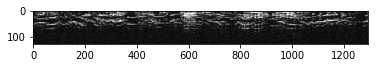

Epoch no 1
Epoch no 2
Epoch no 3
Epoch no 4
Epoch no 5
Epoch no 6
Epoch no 7
Epoch no 8
Epoch no 9
Epoch no 10
Epoch no 11
Epoch no 12
Epoch no 13
Epoch no 14
Epoch no 15
Epoch no 16
Epoch no 17
Epoch no 18
Epoch no 19
Epoch no 20
Epoch no 21
Epoch no 22
Epoch no 23
Epoch no 24
Epoch no 25
Epoch no 26
Epoch no 27
Epoch no 28
Epoch no 29
Epoch no 30
Epoch no 31
Epoch no 32
Epoch no 33
Epoch no 34
Epoch no 35
Epoch no 36
Epoch no 37
Epoch no 38
Epoch no 39
Epoch no 40
Epoch no 41
Epoch no 42
Epoch no 43
Epoch no 44
Epoch no 45
Epoch no 46
Epoch no 47
Epoch no 48
Epoch no 49
Epoch no 50
Epoch no 51
Epoch no 52
Epoch no 53
Epoch no 54
Epoch no 55
Epoch no 56
Epoch no 57
Epoch no 58
Epoch no 59
Epoch no 60
Epoch no 61
Epoch no 62
Epoch no 63
Epoch no 64
Epoch no 65
Epoch no 66
Epoch no 67
Epoch no 68
Epoch no 69
Epoch no 70
Epoch no 71
Epoch no 72
Epoch no 73
Epoch no 74
Epoch no 75
Epoch no 76
Epoch no 77
Epoch no 78
Epoch no 79
Epoch no 80
Epoch no 81
Epoch no 82
Epoch no 83
Epoch no 84
E

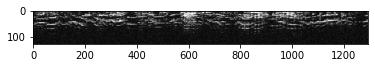

Epoch no 251
Epoch no 252
Epoch no 253
Epoch no 254
Epoch no 255
Epoch no 256
Epoch no 257
Epoch no 258
Epoch no 259
Epoch no 260
Epoch no 261
Epoch no 262
Epoch no 263
Epoch no 264
Epoch no 265
Epoch no 266
Epoch no 267
Epoch no 268
Epoch no 269
Epoch no 270
Epoch no 271
Epoch no 272
Epoch no 273
Epoch no 274
Epoch no 275
Epoch no 276
Epoch no 277
Epoch no 278
Epoch no 279
Epoch no 280
Epoch no 281
Epoch no 282
Epoch no 283
Epoch no 284
Epoch no 285
Epoch no 286
Epoch no 287
Epoch no 288
Epoch no 289
Epoch no 290
Epoch no 291
Epoch no 292
Epoch no 293
Epoch no 294
Epoch no 295
Epoch no 296
Epoch no 297
Epoch no 298
Epoch no 299
Epoch no 300
Epoch no 301
Epoch no 302
Epoch no 303
Epoch no 304
Epoch no 305
Epoch no 306
Epoch no 307
Epoch no 308
Epoch no 309
Epoch no 310
Epoch no 311
Epoch no 312
Epoch no 313
Epoch no 314
Epoch no 315
Epoch no 316
Epoch no 317
Epoch no 318
Epoch no 319
Epoch no 320
Epoch no 321
Epoch no 322
Epoch no 323
Epoch no 324
Epoch no 325
Epoch no 326
Epoch no 327

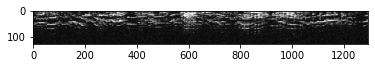

Epoch no 501
Epoch no 502
Epoch no 503
Epoch no 504
Epoch no 505
Epoch no 506
Epoch no 507
Epoch no 508
Epoch no 509
Epoch no 510
Epoch no 511
Epoch no 512
Epoch no 513
Epoch no 514
Epoch no 515
Epoch no 516
Epoch no 517
Epoch no 518
Epoch no 519
Epoch no 520
Epoch no 521
Epoch no 522
Epoch no 523
Epoch no 524
Epoch no 525
Epoch no 526
Epoch no 527
Epoch no 528
Epoch no 529
Epoch no 530
Epoch no 531
Epoch no 532
Epoch no 533
Epoch no 534
Epoch no 535
Epoch no 536
Epoch no 537
Epoch no 538
Epoch no 539
Epoch no 540
Epoch no 541
Epoch no 542
Epoch no 543
Epoch no 544
Epoch no 545
Epoch no 546
Epoch no 547
Epoch no 548
Epoch no 549
Epoch no 550
Epoch no 551
Epoch no 552
Epoch no 553
Epoch no 554
Epoch no 555
Epoch no 556
Epoch no 557
Epoch no 558
Epoch no 559
Epoch no 560
Epoch no 561
Epoch no 562
Epoch no 563
Epoch no 564
Epoch no 565
Epoch no 566
Epoch no 567
Epoch no 568
Epoch no 569
Epoch no 570
Epoch no 571
Epoch no 572
Epoch no 573
Epoch no 574
Epoch no 575
Epoch no 576
Epoch no 577

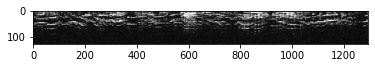

Epoch no 751
Epoch no 752
Epoch no 753
Epoch no 754
Epoch no 755
Epoch no 756
Epoch no 757
Epoch no 758
Epoch no 759
Epoch no 760
Epoch no 761
Epoch no 762
Epoch no 763
Epoch no 764
Epoch no 765
Epoch no 766
Epoch no 767
Epoch no 768
Epoch no 769
Epoch no 770
Epoch no 771
Epoch no 772
Epoch no 773
Epoch no 774
Epoch no 775
Epoch no 776
Epoch no 777
Epoch no 778
Epoch no 779
Epoch no 780
Epoch no 781
Epoch no 782
Epoch no 783
Epoch no 784
Epoch no 785
Epoch no 786
Epoch no 787
Epoch no 788
Epoch no 789
Epoch no 790
Epoch no 791
Epoch no 792
Epoch no 793
Epoch no 794
Epoch no 795
Epoch no 796
Epoch no 797
Epoch no 798
Epoch no 799
Epoch no 800
Epoch no 801
Epoch no 802
Epoch no 803
Epoch no 804
Epoch no 805
Epoch no 806
Epoch no 807
Epoch no 808
Epoch no 809
Epoch no 810
Epoch no 811
Epoch no 812
Epoch no 813
Epoch no 814
Epoch no 815
Epoch no 816
Epoch no 817
Epoch no 818
Epoch no 819
Epoch no 820
Epoch no 821
Epoch no 822
Epoch no 823
Epoch no 824
Epoch no 825
Epoch no 826
Epoch no 827

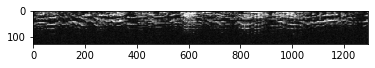

Epoch no 1001
Epoch no 1002
Epoch no 1003
Epoch no 1004
Epoch no 1005
Epoch no 1006
Epoch no 1007
Epoch no 1008
Epoch no 1009
Epoch no 1010
Epoch no 1011
Epoch no 1012
Epoch no 1013
Epoch no 1014
Epoch no 1015
Epoch no 1016
Epoch no 1017
Epoch no 1018
Epoch no 1019
Epoch no 1020
Epoch no 1021
Epoch no 1022
Epoch no 1023
Epoch no 1024
Epoch no 1025
Epoch no 1026
Epoch no 1027
Epoch no 1028
Epoch no 1029
Epoch no 1030
Epoch no 1031
Epoch no 1032
Epoch no 1033
Epoch no 1034
Epoch no 1035
Epoch no 1036
Epoch no 1037
Epoch no 1038
Epoch no 1039
Epoch no 1040
Epoch no 1041
Epoch no 1042
Epoch no 1043
Epoch no 1044
Epoch no 1045
Epoch no 1046
Epoch no 1047
Epoch no 1048
Epoch no 1049
Epoch no 1050
Epoch no 1051
Epoch no 1052
Epoch no 1053
Epoch no 1054
Epoch no 1055
Epoch no 1056
Epoch no 1057
Epoch no 1058
Epoch no 1059
Epoch no 1060
Epoch no 1061
Epoch no 1062
Epoch no 1063
Epoch no 1064
Epoch no 1065
Epoch no 1066
Epoch no 1067
Epoch no 1068
Epoch no 1069
Epoch no 1070
Epoch no 1071
Epoch 

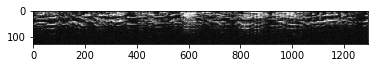

Epoch no 1251
Epoch no 1252
Epoch no 1253
Epoch no 1254
Epoch no 1255
Epoch no 1256
Epoch no 1257
Epoch no 1258
Epoch no 1259
Epoch no 1260
Epoch no 1261
Epoch no 1262
Epoch no 1263
Epoch no 1264
Epoch no 1265
Epoch no 1266
Epoch no 1267
Epoch no 1268
Epoch no 1269
Epoch no 1270
Epoch no 1271
Epoch no 1272
Epoch no 1273
Epoch no 1274
Epoch no 1275
Epoch no 1276
Epoch no 1277
Epoch no 1278
Epoch no 1279
Epoch no 1280
Epoch no 1281
Epoch no 1282
Epoch no 1283
Epoch no 1284
Epoch no 1285
Epoch no 1286
Epoch no 1287
Epoch no 1288
Epoch no 1289
Epoch no 1290
Epoch no 1291
Epoch no 1292
Epoch no 1293
Epoch no 1294
Epoch no 1295
Epoch no 1296
Epoch no 1297
Epoch no 1298
Epoch no 1299
Epoch no 1300
Epoch no 1301
Epoch no 1302
Epoch no 1303
Epoch no 1304
Epoch no 1305
Epoch no 1306
Epoch no 1307
Epoch no 1308
Epoch no 1309
Epoch no 1310
Epoch no 1311
Epoch no 1312
Epoch no 1313
Epoch no 1314
Epoch no 1315
Epoch no 1316
Epoch no 1317
Epoch no 1318
Epoch no 1319
Epoch no 1320
Epoch no 1321
Epoch 

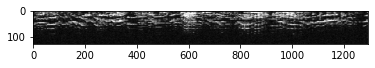

Epoch no 1501
Epoch no 1502
Epoch no 1503
Epoch no 1504
Epoch no 1505
Epoch no 1506
Epoch no 1507
Epoch no 1508
Epoch no 1509
Epoch no 1510
Epoch no 1511
Epoch no 1512
Epoch no 1513
Epoch no 1514
Epoch no 1515
Epoch no 1516
Epoch no 1517
Epoch no 1518
Epoch no 1519
Epoch no 1520
Epoch no 1521
Epoch no 1522
Epoch no 1523
Epoch no 1524
Epoch no 1525
Epoch no 1526
Epoch no 1527
Epoch no 1528
Epoch no 1529
Epoch no 1530
Epoch no 1531
Epoch no 1532
Epoch no 1533
Epoch no 1534
Epoch no 1535
Epoch no 1536
Epoch no 1537
Epoch no 1538
Epoch no 1539
Epoch no 1540
Epoch no 1541
Epoch no 1542
Epoch no 1543
Epoch no 1544
Epoch no 1545
Epoch no 1546
Epoch no 1547
Epoch no 1548
Epoch no 1549
Epoch no 1550
Epoch no 1551
Epoch no 1552
Epoch no 1553
Epoch no 1554
Epoch no 1555
Epoch no 1556
Epoch no 1557
Epoch no 1558
Epoch no 1559
Epoch no 1560
Epoch no 1561
Epoch no 1562
Epoch no 1563
Epoch no 1564
Epoch no 1565
Epoch no 1566
Epoch no 1567
Epoch no 1568
Epoch no 1569
Epoch no 1570
Epoch no 1571
Epoch 

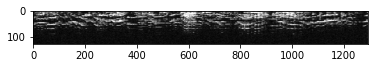

Epoch no 1751
Epoch no 1752
Epoch no 1753
Epoch no 1754
Epoch no 1755
Epoch no 1756
Epoch no 1757
Epoch no 1758
Epoch no 1759
Epoch no 1760
Epoch no 1761
Epoch no 1762
Epoch no 1763
Epoch no 1764
Epoch no 1765
Epoch no 1766
Epoch no 1767
Epoch no 1768
Epoch no 1769
Epoch no 1770
Epoch no 1771
Epoch no 1772
Epoch no 1773
Epoch no 1774
Epoch no 1775
Epoch no 1776
Epoch no 1777
Epoch no 1778
Epoch no 1779
Epoch no 1780
Epoch no 1781
Epoch no 1782
Epoch no 1783
Epoch no 1784
Epoch no 1785
Epoch no 1786
Epoch no 1787
Epoch no 1788
Epoch no 1789
Epoch no 1790
Epoch no 1791
Epoch no 1792
Epoch no 1793
Epoch no 1794
Epoch no 1795
Epoch no 1796
Epoch no 1797
Epoch no 1798
Epoch no 1799
Epoch no 1800
Epoch no 1801
Epoch no 1802
Epoch no 1803
Epoch no 1804
Epoch no 1805
Epoch no 1806
Epoch no 1807
Epoch no 1808
Epoch no 1809
Epoch no 1810
Epoch no 1811
Epoch no 1812
Epoch no 1813
Epoch no 1814
Epoch no 1815
Epoch no 1816
Epoch no 1817
Epoch no 1818
Epoch no 1819
Epoch no 1820
Epoch no 1821
Epoch 

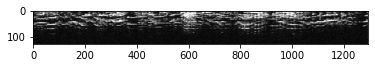

Epoch no 2001
Epoch no 2002
Epoch no 2003
Epoch no 2004
Epoch no 2005
Epoch no 2006
Epoch no 2007
Epoch no 2008
Epoch no 2009
Epoch no 2010
Epoch no 2011
Epoch no 2012
Epoch no 2013
Epoch no 2014
Epoch no 2015
Epoch no 2016
Epoch no 2017
Epoch no 2018
Epoch no 2019
Epoch no 2020
Epoch no 2021
Epoch no 2022
Epoch no 2023
Epoch no 2024
Epoch no 2025
Epoch no 2026
Epoch no 2027
Epoch no 2028
Epoch no 2029
Epoch no 2030
Epoch no 2031
Epoch no 2032
Epoch no 2033
Epoch no 2034
Epoch no 2035
Epoch no 2036
Epoch no 2037
Epoch no 2038
Epoch no 2039
Epoch no 2040
Epoch no 2041
Epoch no 2042
Epoch no 2043
Epoch no 2044
Epoch no 2045
Epoch no 2046
Epoch no 2047
Epoch no 2048
Epoch no 2049
Epoch no 2050
Epoch no 2051
Epoch no 2052
Epoch no 2053
Epoch no 2054
Epoch no 2055
Epoch no 2056
Epoch no 2057
Epoch no 2058
Epoch no 2059
Epoch no 2060
Epoch no 2061
Epoch no 2062
Epoch no 2063
Epoch no 2064
Epoch no 2065
Epoch no 2066
Epoch no 2067
Epoch no 2068
Epoch no 2069
Epoch no 2070
Epoch no 2071
Epoch 

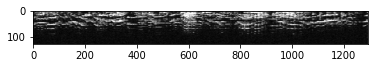

Epoch no 2251
Epoch no 2252
Epoch no 2253
Epoch no 2254
Epoch no 2255
Epoch no 2256
Epoch no 2257
Epoch no 2258
Epoch no 2259
Epoch no 2260
Epoch no 2261
Epoch no 2262
Epoch no 2263
Epoch no 2264
Epoch no 2265
Epoch no 2266
Epoch no 2267
Epoch no 2268
Epoch no 2269
Epoch no 2270
Epoch no 2271
Epoch no 2272
Epoch no 2273
Epoch no 2274
Epoch no 2275
Epoch no 2276
Epoch no 2277
Epoch no 2278
Epoch no 2279
Epoch no 2280
Epoch no 2281
Epoch no 2282
Epoch no 2283
Epoch no 2284
Epoch no 2285
Epoch no 2286
Epoch no 2287
Epoch no 2288
Epoch no 2289
Epoch no 2290
Epoch no 2291
Epoch no 2292
Epoch no 2293
Epoch no 2294
Epoch no 2295
Epoch no 2296
Epoch no 2297
Epoch no 2298
Epoch no 2299
Epoch no 2300
Epoch no 2301
Epoch no 2302
Epoch no 2303
Epoch no 2304
Epoch no 2305
Epoch no 2306
Epoch no 2307
Epoch no 2308
Epoch no 2309
Epoch no 2310
Epoch no 2311
Epoch no 2312
Epoch no 2313
Epoch no 2314
Epoch no 2315
Epoch no 2316
Epoch no 2317
Epoch no 2318
Epoch no 2319
Epoch no 2320
Epoch no 2321
Epoch 

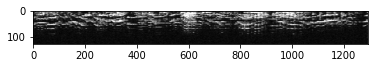

Epoch no 2501
Epoch no 2502
Epoch no 2503
Epoch no 2504
Epoch no 2505
Epoch no 2506
Epoch no 2507
Epoch no 2508
Epoch no 2509
Epoch no 2510
Epoch no 2511
Epoch no 2512
Epoch no 2513
Epoch no 2514
Epoch no 2515
Epoch no 2516
Epoch no 2517
Epoch no 2518
Epoch no 2519
Epoch no 2520
Epoch no 2521
Epoch no 2522
Epoch no 2523
Epoch no 2524
Epoch no 2525
Epoch no 2526
Epoch no 2527
Epoch no 2528
Epoch no 2529
Epoch no 2530
Epoch no 2531
Epoch no 2532
Epoch no 2533
Epoch no 2534
Epoch no 2535
Epoch no 2536
Epoch no 2537
Epoch no 2538
Epoch no 2539
Epoch no 2540
Epoch no 2541
Epoch no 2542
Epoch no 2543
Epoch no 2544
Epoch no 2545
Epoch no 2546
Epoch no 2547
Epoch no 2548
Epoch no 2549
Epoch no 2550
Epoch no 2551
Epoch no 2552
Epoch no 2553
Epoch no 2554
Epoch no 2555
Epoch no 2556
Epoch no 2557
Epoch no 2558
Epoch no 2559
Epoch no 2560
Epoch no 2561
Epoch no 2562
Epoch no 2563
Epoch no 2564
Epoch no 2565
Epoch no 2566
Epoch no 2567
Epoch no 2568
Epoch no 2569
Epoch no 2570
Epoch no 2571
Epoch 

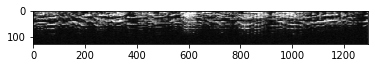

Epoch no 2751
Epoch no 2752
Epoch no 2753
Epoch no 2754
Epoch no 2755
Epoch no 2756
Epoch no 2757
Epoch no 2758
Epoch no 2759
Epoch no 2760
Epoch no 2761
Epoch no 2762
Epoch no 2763
Epoch no 2764
Epoch no 2765
Epoch no 2766
Epoch no 2767
Epoch no 2768
Epoch no 2769
Epoch no 2770
Epoch no 2771
Epoch no 2772
Epoch no 2773
Epoch no 2774
Epoch no 2775
Epoch no 2776
Epoch no 2777
Epoch no 2778
Epoch no 2779
Epoch no 2780
Epoch no 2781
Epoch no 2782
Epoch no 2783
Epoch no 2784
Epoch no 2785
Epoch no 2786
Epoch no 2787
Epoch no 2788
Epoch no 2789
Epoch no 2790
Epoch no 2791
Epoch no 2792
Epoch no 2793
Epoch no 2794
Epoch no 2795
Epoch no 2796
Epoch no 2797
Epoch no 2798
Epoch no 2799
Epoch no 2800
Epoch no 2801
Epoch no 2802
Epoch no 2803
Epoch no 2804
Epoch no 2805
Epoch no 2806
Epoch no 2807
Epoch no 2808
Epoch no 2809
Epoch no 2810
Epoch no 2811
Epoch no 2812
Epoch no 2813
Epoch no 2814
Epoch no 2815
Epoch no 2816
Epoch no 2817
Epoch no 2818
Epoch no 2819
Epoch no 2820
Epoch no 2821
Epoch 

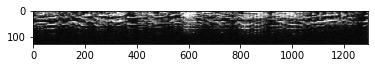

Epoch no 3001
Epoch no 3002
Epoch no 3003
Epoch no 3004
Epoch no 3005
Epoch no 3006
Epoch no 3007
Epoch no 3008
Epoch no 3009
Epoch no 3010
Epoch no 3011
Epoch no 3012
Epoch no 3013
Epoch no 3014
Epoch no 3015
Epoch no 3016
Epoch no 3017
Epoch no 3018
Epoch no 3019
Epoch no 3020
Epoch no 3021
Epoch no 3022
Epoch no 3023
Epoch no 3024
Epoch no 3025
Epoch no 3026
Epoch no 3027
Epoch no 3028
Epoch no 3029
Epoch no 3030
Epoch no 3031
Epoch no 3032
Epoch no 3033
Epoch no 3034
Epoch no 3035
Epoch no 3036
Epoch no 3037
Epoch no 3038
Epoch no 3039
Epoch no 3040
Epoch no 3041
Epoch no 3042
Epoch no 3043
Epoch no 3044
Epoch no 3045
Epoch no 3046
Epoch no 3047
Epoch no 3048
Epoch no 3049
Epoch no 3050
Epoch no 3051
Epoch no 3052
Epoch no 3053
Epoch no 3054
Epoch no 3055
Epoch no 3056
Epoch no 3057
Epoch no 3058
Epoch no 3059
Epoch no 3060
Epoch no 3061
Epoch no 3062
Epoch no 3063
Epoch no 3064
Epoch no 3065
Epoch no 3066
Epoch no 3067
Epoch no 3068
Epoch no 3069
Epoch no 3070
Epoch no 3071
Epoch 

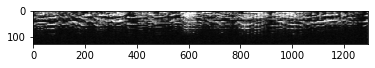

Epoch no 3251
Epoch no 3252
Epoch no 3253
Epoch no 3254
Epoch no 3255
Epoch no 3256
Epoch no 3257
Epoch no 3258
Epoch no 3259
Epoch no 3260
Epoch no 3261
Epoch no 3262
Epoch no 3263
Epoch no 3264
Epoch no 3265
Epoch no 3266
Epoch no 3267
Epoch no 3268
Epoch no 3269
Epoch no 3270
Epoch no 3271
Epoch no 3272
Epoch no 3273
Epoch no 3274
Epoch no 3275
Epoch no 3276
Epoch no 3277
Epoch no 3278
Epoch no 3279
Epoch no 3280
Epoch no 3281
Epoch no 3282
Epoch no 3283
Epoch no 3284
Epoch no 3285
Epoch no 3286
Epoch no 3287
Epoch no 3288
Epoch no 3289
Epoch no 3290
Epoch no 3291
Epoch no 3292
Epoch no 3293
Epoch no 3294
Epoch no 3295
Epoch no 3296
Epoch no 3297
Epoch no 3298
Epoch no 3299
Epoch no 3300
Epoch no 3301
Epoch no 3302
Epoch no 3303
Epoch no 3304
Epoch no 3305
Epoch no 3306
Epoch no 3307
Epoch no 3308
Epoch no 3309
Epoch no 3310
Epoch no 3311
Epoch no 3312
Epoch no 3313
Epoch no 3314
Epoch no 3315
Epoch no 3316
Epoch no 3317
Epoch no 3318
Epoch no 3319
Epoch no 3320
Epoch no 3321
Epoch 

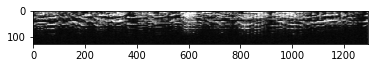

Epoch no 3501
Epoch no 3502
Epoch no 3503
Epoch no 3504
Epoch no 3505
Epoch no 3506
Epoch no 3507
Epoch no 3508
Epoch no 3509
Epoch no 3510
Epoch no 3511
Epoch no 3512
Epoch no 3513
Epoch no 3514
Epoch no 3515
Epoch no 3516
Epoch no 3517
Epoch no 3518
Epoch no 3519
Epoch no 3520
Epoch no 3521
Epoch no 3522
Epoch no 3523
Epoch no 3524
Epoch no 3525
Epoch no 3526
Epoch no 3527
Epoch no 3528
Epoch no 3529
Epoch no 3530
Epoch no 3531
Epoch no 3532
Epoch no 3533
Epoch no 3534
Epoch no 3535
Epoch no 3536
Epoch no 3537
Epoch no 3538
Epoch no 3539
Epoch no 3540
Epoch no 3541
Epoch no 3542
Epoch no 3543
Epoch no 3544
Epoch no 3545
Epoch no 3546
Epoch no 3547
Epoch no 3548
Epoch no 3549
Epoch no 3550
Epoch no 3551
Epoch no 3552
Epoch no 3553
Epoch no 3554
Epoch no 3555
Epoch no 3556
Epoch no 3557
Epoch no 3558
Epoch no 3559
Epoch no 3560
Epoch no 3561
Epoch no 3562
Epoch no 3563
Epoch no 3564
Epoch no 3565
Epoch no 3566
Epoch no 3567
Epoch no 3568
Epoch no 3569
Epoch no 3570
Epoch no 3571
Epoch 

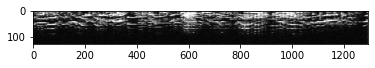

Epoch no 3751
Epoch no 3752
Epoch no 3753
Epoch no 3754
Epoch no 3755
Epoch no 3756
Epoch no 3757
Epoch no 3758
Epoch no 3759
Epoch no 3760
Epoch no 3761
Epoch no 3762
Epoch no 3763
Epoch no 3764
Epoch no 3765
Epoch no 3766
Epoch no 3767
Epoch no 3768
Epoch no 3769
Epoch no 3770
Epoch no 3771
Epoch no 3772
Epoch no 3773
Epoch no 3774
Epoch no 3775
Epoch no 3776
Epoch no 3777
Epoch no 3778
Epoch no 3779
Epoch no 3780
Epoch no 3781
Epoch no 3782
Epoch no 3783
Epoch no 3784
Epoch no 3785
Epoch no 3786
Epoch no 3787
Epoch no 3788
Epoch no 3789
Epoch no 3790
Epoch no 3791
Epoch no 3792
Epoch no 3793
Epoch no 3794
Epoch no 3795
Epoch no 3796
Epoch no 3797
Epoch no 3798
Epoch no 3799
Epoch no 3800
Epoch no 3801
Epoch no 3802
Epoch no 3803
Epoch no 3804
Epoch no 3805
Epoch no 3806
Epoch no 3807
Epoch no 3808
Epoch no 3809
Epoch no 3810
Epoch no 3811
Epoch no 3812
Epoch no 3813
Epoch no 3814
Epoch no 3815
Epoch no 3816
Epoch no 3817
Epoch no 3818
Epoch no 3819
Epoch no 3820
Epoch no 3821
Epoch 

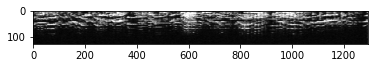

Epoch no 4001
Epoch no 4002
Epoch no 4003
Epoch no 4004
Epoch no 4005
Epoch no 4006
Epoch no 4007
Epoch no 4008
Epoch no 4009
Epoch no 4010
Epoch no 4011
Epoch no 4012
Epoch no 4013
Epoch no 4014
Epoch no 4015
Epoch no 4016
Epoch no 4017
Epoch no 4018
Epoch no 4019
Epoch no 4020
Epoch no 4021
Epoch no 4022
Epoch no 4023
Epoch no 4024
Epoch no 4025
Epoch no 4026
Epoch no 4027
Epoch no 4028
Epoch no 4029
Epoch no 4030
Epoch no 4031
Epoch no 4032
Epoch no 4033
Epoch no 4034
Epoch no 4035
Epoch no 4036
Epoch no 4037
Epoch no 4038
Epoch no 4039
Epoch no 4040
Epoch no 4041
Epoch no 4042
Epoch no 4043
Epoch no 4044
Epoch no 4045
Epoch no 4046
Epoch no 4047
Epoch no 4048
Epoch no 4049
Epoch no 4050
Epoch no 4051
Epoch no 4052
Epoch no 4053
Epoch no 4054
Epoch no 4055
Epoch no 4056
Epoch no 4057
Epoch no 4058
Epoch no 4059
Epoch no 4060
Epoch no 4061
Epoch no 4062
Epoch no 4063
Epoch no 4064
Epoch no 4065
Epoch no 4066
Epoch no 4067
Epoch no 4068
Epoch no 4069
Epoch no 4070
Epoch no 4071
Epoch 

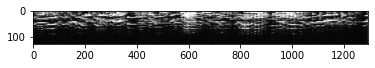

Epoch no 4251
Epoch no 4252
Epoch no 4253
Epoch no 4254
Epoch no 4255
Epoch no 4256
Epoch no 4257
Epoch no 4258
Epoch no 4259
Epoch no 4260
Epoch no 4261
Epoch no 4262
Epoch no 4263
Epoch no 4264
Epoch no 4265
Epoch no 4266
Epoch no 4267
Epoch no 4268
Epoch no 4269
Epoch no 4270
Epoch no 4271
Epoch no 4272
Epoch no 4273
Epoch no 4274
Epoch no 4275
Epoch no 4276
Epoch no 4277
Epoch no 4278
Epoch no 4279
Epoch no 4280
Epoch no 4281
Epoch no 4282
Epoch no 4283
Epoch no 4284
Epoch no 4285
Epoch no 4286
Epoch no 4287
Epoch no 4288
Epoch no 4289
Epoch no 4290
Epoch no 4291
Epoch no 4292
Epoch no 4293
Epoch no 4294
Epoch no 4295
Epoch no 4296
Epoch no 4297
Epoch no 4298
Epoch no 4299
Epoch no 4300
Epoch no 4301
Epoch no 4302
Epoch no 4303
Epoch no 4304
Epoch no 4305
Epoch no 4306
Epoch no 4307
Epoch no 4308
Epoch no 4309
Epoch no 4310
Epoch no 4311
Epoch no 4312
Epoch no 4313
Epoch no 4314
Epoch no 4315
Epoch no 4316
Epoch no 4317
Epoch no 4318
Epoch no 4319
Epoch no 4320
Epoch no 4321
Epoch 

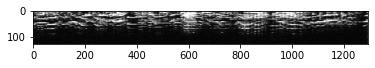

Epoch no 4501
Epoch no 4502
Epoch no 4503
Epoch no 4504
Epoch no 4505
Epoch no 4506
Epoch no 4507
Epoch no 4508
Epoch no 4509
Epoch no 4510
Epoch no 4511
Epoch no 4512
Epoch no 4513
Epoch no 4514
Epoch no 4515
Epoch no 4516
Epoch no 4517
Epoch no 4518
Epoch no 4519
Epoch no 4520
Epoch no 4521
Epoch no 4522
Epoch no 4523
Epoch no 4524
Epoch no 4525
Epoch no 4526
Epoch no 4527
Epoch no 4528
Epoch no 4529
Epoch no 4530
Epoch no 4531
Epoch no 4532
Epoch no 4533
Epoch no 4534
Epoch no 4535
Epoch no 4536
Epoch no 4537
Epoch no 4538
Epoch no 4539
Epoch no 4540
Epoch no 4541
Epoch no 4542
Epoch no 4543
Epoch no 4544
Epoch no 4545
Epoch no 4546
Epoch no 4547
Epoch no 4548
Epoch no 4549
Epoch no 4550
Epoch no 4551
Epoch no 4552
Epoch no 4553
Epoch no 4554
Epoch no 4555
Epoch no 4556
Epoch no 4557
Epoch no 4558
Epoch no 4559
Epoch no 4560
Epoch no 4561
Epoch no 4562
Epoch no 4563
Epoch no 4564
Epoch no 4565
Epoch no 4566
Epoch no 4567
Epoch no 4568
Epoch no 4569
Epoch no 4570
Epoch no 4571
Epoch 

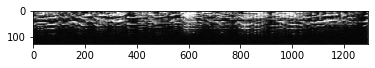

Epoch no 4751
Epoch no 4752
Epoch no 4753
Epoch no 4754
Epoch no 4755
Epoch no 4756
Epoch no 4757
Epoch no 4758
Epoch no 4759
Epoch no 4760
Epoch no 4761
Epoch no 4762
Epoch no 4763
Epoch no 4764
Epoch no 4765
Epoch no 4766
Epoch no 4767
Epoch no 4768
Epoch no 4769
Epoch no 4770
Epoch no 4771
Epoch no 4772
Epoch no 4773
Epoch no 4774
Epoch no 4775
Epoch no 4776
Epoch no 4777
Epoch no 4778
Epoch no 4779
Epoch no 4780
Epoch no 4781
Epoch no 4782
Epoch no 4783
Epoch no 4784
Epoch no 4785
Epoch no 4786
Epoch no 4787
Epoch no 4788
Epoch no 4789
Epoch no 4790
Epoch no 4791
Epoch no 4792
Epoch no 4793
Epoch no 4794
Epoch no 4795
Epoch no 4796
Epoch no 4797
Epoch no 4798
Epoch no 4799
Epoch no 4800
Epoch no 4801
Epoch no 4802
Epoch no 4803
Epoch no 4804
Epoch no 4805
Epoch no 4806
Epoch no 4807
Epoch no 4808
Epoch no 4809
Epoch no 4810
Epoch no 4811
Epoch no 4812
Epoch no 4813
Epoch no 4814
Epoch no 4815
Epoch no 4816
Epoch no 4817
Epoch no 4818
Epoch no 4819
Epoch no 4820
Epoch no 4821
Epoch 

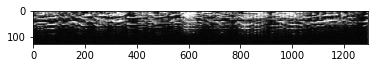

Epoch no 5001
Epoch no 5002
Epoch no 5003
Epoch no 5004
Epoch no 5005
Epoch no 5006
Epoch no 5007
Epoch no 5008
Epoch no 5009
Epoch no 5010
Epoch no 5011
Epoch no 5012
Epoch no 5013
Epoch no 5014
Epoch no 5015
Epoch no 5016
Epoch no 5017
Epoch no 5018
Epoch no 5019
Epoch no 5020
Epoch no 5021
Epoch no 5022
Epoch no 5023
Epoch no 5024
Epoch no 5025
Epoch no 5026
Epoch no 5027
Epoch no 5028
Epoch no 5029
Epoch no 5030
Epoch no 5031
Epoch no 5032
Epoch no 5033
Epoch no 5034
Epoch no 5035
Epoch no 5036
Epoch no 5037
Epoch no 5038
Epoch no 5039
Epoch no 5040
Epoch no 5041
Epoch no 5042
Epoch no 5043
Epoch no 5044
Epoch no 5045
Epoch no 5046
Epoch no 5047
Epoch no 5048
Epoch no 5049
Epoch no 5050
Epoch no 5051
Epoch no 5052
Epoch no 5053
Epoch no 5054
Epoch no 5055
Epoch no 5056
Epoch no 5057
Epoch no 5058
Epoch no 5059
Epoch no 5060
Epoch no 5061
Epoch no 5062
Epoch no 5063
Epoch no 5064
Epoch no 5065
Epoch no 5066
Epoch no 5067
Epoch no 5068
Epoch no 5069
Epoch no 5070
Epoch no 5071
Epoch 

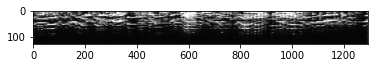

Epoch no 5251
Epoch no 5252
Epoch no 5253
Epoch no 5254
Epoch no 5255
Epoch no 5256
Epoch no 5257
Epoch no 5258
Epoch no 5259
Epoch no 5260
Epoch no 5261
Epoch no 5262
Epoch no 5263
Epoch no 5264
Epoch no 5265
Epoch no 5266
Epoch no 5267
Epoch no 5268
Epoch no 5269
Epoch no 5270
Epoch no 5271
Epoch no 5272
Epoch no 5273
Epoch no 5274
Epoch no 5275
Epoch no 5276
Epoch no 5277
Epoch no 5278
Epoch no 5279
Epoch no 5280
Epoch no 5281
Epoch no 5282
Epoch no 5283
Epoch no 5284
Epoch no 5285
Epoch no 5286
Epoch no 5287
Epoch no 5288
Epoch no 5289
Epoch no 5290
Epoch no 5291
Epoch no 5292
Epoch no 5293
Epoch no 5294
Epoch no 5295
Epoch no 5296
Epoch no 5297
Epoch no 5298
Epoch no 5299
Epoch no 5300
Epoch no 5301
Epoch no 5302
Epoch no 5303
Epoch no 5304
Epoch no 5305
Epoch no 5306
Epoch no 5307
Epoch no 5308
Epoch no 5309
Epoch no 5310
Epoch no 5311
Epoch no 5312
Epoch no 5313
Epoch no 5314
Epoch no 5315
Epoch no 5316
Epoch no 5317
Epoch no 5318
Epoch no 5319
Epoch no 5320
Epoch no 5321
Epoch 

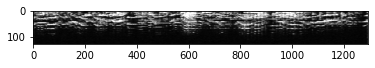

Epoch no 5501
Epoch no 5502
Epoch no 5503
Epoch no 5504
Epoch no 5505
Epoch no 5506
Epoch no 5507
Epoch no 5508
Epoch no 5509
Epoch no 5510
Epoch no 5511
Epoch no 5512
Epoch no 5513
Epoch no 5514
Epoch no 5515
Epoch no 5516
Epoch no 5517
Epoch no 5518
Epoch no 5519
Epoch no 5520
Epoch no 5521
Epoch no 5522
Epoch no 5523
Epoch no 5524
Epoch no 5525
Epoch no 5526
Epoch no 5527
Epoch no 5528
Epoch no 5529
Epoch no 5530
Epoch no 5531
Epoch no 5532
Epoch no 5533
Epoch no 5534
Epoch no 5535
Epoch no 5536
Epoch no 5537
Epoch no 5538
Epoch no 5539
Epoch no 5540
Epoch no 5541
Epoch no 5542
Epoch no 5543
Epoch no 5544
Epoch no 5545
Epoch no 5546
Epoch no 5547
Epoch no 5548
Epoch no 5549
Epoch no 5550
Epoch no 5551
Epoch no 5552
Epoch no 5553
Epoch no 5554
Epoch no 5555
Epoch no 5556
Epoch no 5557
Epoch no 5558
Epoch no 5559
Epoch no 5560
Epoch no 5561
Epoch no 5562
Epoch no 5563
Epoch no 5564
Epoch no 5565
Epoch no 5566
Epoch no 5567
Epoch no 5568
Epoch no 5569
Epoch no 5570
Epoch no 5571
Epoch 

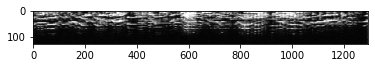

Epoch no 5751
Epoch no 5752
Epoch no 5753
Epoch no 5754
Epoch no 5755
Epoch no 5756
Epoch no 5757
Epoch no 5758
Epoch no 5759
Epoch no 5760
Epoch no 5761
Epoch no 5762
Epoch no 5763
Epoch no 5764
Epoch no 5765
Epoch no 5766
Epoch no 5767
Epoch no 5768
Epoch no 5769
Epoch no 5770
Epoch no 5771
Epoch no 5772
Epoch no 5773
Epoch no 5774
Epoch no 5775
Epoch no 5776
Epoch no 5777
Epoch no 5778
Epoch no 5779
Epoch no 5780
Epoch no 5781
Epoch no 5782
Epoch no 5783
Epoch no 5784
Epoch no 5785
Epoch no 5786
Epoch no 5787
Epoch no 5788
Epoch no 5789
Epoch no 5790
Epoch no 5791
Epoch no 5792
Epoch no 5793
Epoch no 5794
Epoch no 5795
Epoch no 5796
Epoch no 5797
Epoch no 5798
Epoch no 5799
Epoch no 5800
Epoch no 5801
Epoch no 5802
Epoch no 5803
Epoch no 5804
Epoch no 5805
Epoch no 5806
Epoch no 5807
Epoch no 5808
Epoch no 5809
Epoch no 5810
Epoch no 5811
Epoch no 5812
Epoch no 5813
Epoch no 5814
Epoch no 5815
Epoch no 5816
Epoch no 5817
Epoch no 5818
Epoch no 5819
Epoch no 5820
Epoch no 5821
Epoch 

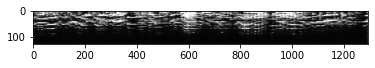

Epoch no 6001
Epoch no 6002
Epoch no 6003
Epoch no 6004
Epoch no 6005
Epoch no 6006
Epoch no 6007
Epoch no 6008
Epoch no 6009
Epoch no 6010
Epoch no 6011
Epoch no 6012
Epoch no 6013
Epoch no 6014
Epoch no 6015
Epoch no 6016
Epoch no 6017
Epoch no 6018
Epoch no 6019
Epoch no 6020
Epoch no 6021
Epoch no 6022
Epoch no 6023
Epoch no 6024
Epoch no 6025
Epoch no 6026
Epoch no 6027
Epoch no 6028
Epoch no 6029
Epoch no 6030
Epoch no 6031
Epoch no 6032
Epoch no 6033
Epoch no 6034
Epoch no 6035
Epoch no 6036
Epoch no 6037
Epoch no 6038
Epoch no 6039
Epoch no 6040
Epoch no 6041
Epoch no 6042
Epoch no 6043
Epoch no 6044
Epoch no 6045
Epoch no 6046
Epoch no 6047
Epoch no 6048
Epoch no 6049
Epoch no 6050
Epoch no 6051
Epoch no 6052
Epoch no 6053
Epoch no 6054
Epoch no 6055
Epoch no 6056
Epoch no 6057
Epoch no 6058
Epoch no 6059
Epoch no 6060
Epoch no 6061
Epoch no 6062
Epoch no 6063
Epoch no 6064
Epoch no 6065
Epoch no 6066
Epoch no 6067
Epoch no 6068
Epoch no 6069
Epoch no 6070
Epoch no 6071
Epoch 

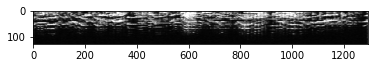

Epoch no 6251
Epoch no 6252
Epoch no 6253
Epoch no 6254
Epoch no 6255
Epoch no 6256
Epoch no 6257
Epoch no 6258
Epoch no 6259
Epoch no 6260
Epoch no 6261
Epoch no 6262
Epoch no 6263
Epoch no 6264
Epoch no 6265
Epoch no 6266
Epoch no 6267
Epoch no 6268
Epoch no 6269
Epoch no 6270
Epoch no 6271
Epoch no 6272
Epoch no 6273
Epoch no 6274
Epoch no 6275
Epoch no 6276
Epoch no 6277
Epoch no 6278
Epoch no 6279
Epoch no 6280
Epoch no 6281
Epoch no 6282
Epoch no 6283
Epoch no 6284
Epoch no 6285
Epoch no 6286
Epoch no 6287
Epoch no 6288
Epoch no 6289
Epoch no 6290
Epoch no 6291
Epoch no 6292
Epoch no 6293
Epoch no 6294
Epoch no 6295
Epoch no 6296
Epoch no 6297
Epoch no 6298
Epoch no 6299
Epoch no 6300
Epoch no 6301
Epoch no 6302
Epoch no 6303
Epoch no 6304
Epoch no 6305
Epoch no 6306
Epoch no 6307
Epoch no 6308
Epoch no 6309
Epoch no 6310
Epoch no 6311
Epoch no 6312
Epoch no 6313
Epoch no 6314
Epoch no 6315
Epoch no 6316
Epoch no 6317
Epoch no 6318
Epoch no 6319
Epoch no 6320
Epoch no 6321
Epoch 

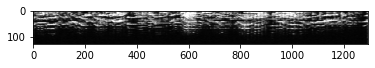

Epoch no 6501
Epoch no 6502
Epoch no 6503
Epoch no 6504
Epoch no 6505
Epoch no 6506
Epoch no 6507
Epoch no 6508
Epoch no 6509
Epoch no 6510
Epoch no 6511
Epoch no 6512
Epoch no 6513
Epoch no 6514
Epoch no 6515
Epoch no 6516
Epoch no 6517
Epoch no 6518
Epoch no 6519
Epoch no 6520
Epoch no 6521
Epoch no 6522
Epoch no 6523
Epoch no 6524
Epoch no 6525
Epoch no 6526
Epoch no 6527
Epoch no 6528
Epoch no 6529
Epoch no 6530
Epoch no 6531
Epoch no 6532
Epoch no 6533
Epoch no 6534
Epoch no 6535
Epoch no 6536
Epoch no 6537
Epoch no 6538
Epoch no 6539
Epoch no 6540
Epoch no 6541
Epoch no 6542
Epoch no 6543
Epoch no 6544
Epoch no 6545
Epoch no 6546
Epoch no 6547
Epoch no 6548
Epoch no 6549
Epoch no 6550
Epoch no 6551
Epoch no 6552
Epoch no 6553
Epoch no 6554
Epoch no 6555
Epoch no 6556
Epoch no 6557
Epoch no 6558
Epoch no 6559
Epoch no 6560
Epoch no 6561
Epoch no 6562
Epoch no 6563
Epoch no 6564
Epoch no 6565
Epoch no 6566
Epoch no 6567
Epoch no 6568
Epoch no 6569
Epoch no 6570
Epoch no 6571
Epoch 

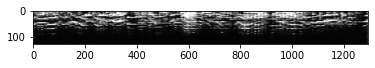

Epoch no 6751
Epoch no 6752
Epoch no 6753
Epoch no 6754
Epoch no 6755
Epoch no 6756
Epoch no 6757
Epoch no 6758
Epoch no 6759
Epoch no 6760
Epoch no 6761
Epoch no 6762
Epoch no 6763
Epoch no 6764
Epoch no 6765
Epoch no 6766
Epoch no 6767
Epoch no 6768
Epoch no 6769
Epoch no 6770
Epoch no 6771
Epoch no 6772
Epoch no 6773
Epoch no 6774
Epoch no 6775
Epoch no 6776
Epoch no 6777
Epoch no 6778
Epoch no 6779
Epoch no 6780
Epoch no 6781
Epoch no 6782
Epoch no 6783
Epoch no 6784
Epoch no 6785
Epoch no 6786
Epoch no 6787
Epoch no 6788
Epoch no 6789
Epoch no 6790
Epoch no 6791
Epoch no 6792
Epoch no 6793
Epoch no 6794
Epoch no 6795
Epoch no 6796
Epoch no 6797
Epoch no 6798
Epoch no 6799
Epoch no 6800
Epoch no 6801
Epoch no 6802
Epoch no 6803
Epoch no 6804
Epoch no 6805
Epoch no 6806
Epoch no 6807
Epoch no 6808
Epoch no 6809
Epoch no 6810
Epoch no 6811
Epoch no 6812
Epoch no 6813
Epoch no 6814
Epoch no 6815
Epoch no 6816
Epoch no 6817
Epoch no 6818
Epoch no 6819
Epoch no 6820
Epoch no 6821
Epoch 

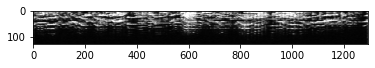

Epoch no 7001
Epoch no 7002
Epoch no 7003
Epoch no 7004
Epoch no 7005
Epoch no 7006
Epoch no 7007
Epoch no 7008
Epoch no 7009
Epoch no 7010
Epoch no 7011
Epoch no 7012
Epoch no 7013
Epoch no 7014
Epoch no 7015
Epoch no 7016
Epoch no 7017
Epoch no 7018
Epoch no 7019
Epoch no 7020
Epoch no 7021
Epoch no 7022
Epoch no 7023
Epoch no 7024
Epoch no 7025
Epoch no 7026
Epoch no 7027
Epoch no 7028
Epoch no 7029
Epoch no 7030
Epoch no 7031
Epoch no 7032
Epoch no 7033
Epoch no 7034
Epoch no 7035
Epoch no 7036
Epoch no 7037
Epoch no 7038
Epoch no 7039
Epoch no 7040
Epoch no 7041
Epoch no 7042
Epoch no 7043
Epoch no 7044
Epoch no 7045
Epoch no 7046
Epoch no 7047
Epoch no 7048
Epoch no 7049
Epoch no 7050
Epoch no 7051
Epoch no 7052
Epoch no 7053
Epoch no 7054
Epoch no 7055
Epoch no 7056
Epoch no 7057
Epoch no 7058
Epoch no 7059
Epoch no 7060
Epoch no 7061
Epoch no 7062
Epoch no 7063
Epoch no 7064
Epoch no 7065
Epoch no 7066
Epoch no 7067
Epoch no 7068
Epoch no 7069
Epoch no 7070
Epoch no 7071
Epoch 

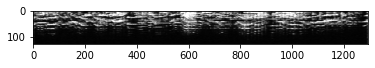

Epoch no 7251
Epoch no 7252
Epoch no 7253
Epoch no 7254
Epoch no 7255
Epoch no 7256
Epoch no 7257
Epoch no 7258
Epoch no 7259
Epoch no 7260
Epoch no 7261
Epoch no 7262
Epoch no 7263
Epoch no 7264
Epoch no 7265
Epoch no 7266
Epoch no 7267
Epoch no 7268
Epoch no 7269
Epoch no 7270
Epoch no 7271
Epoch no 7272
Epoch no 7273
Epoch no 7274
Epoch no 7275
Epoch no 7276
Epoch no 7277
Epoch no 7278
Epoch no 7279
Epoch no 7280
Epoch no 7281
Epoch no 7282
Epoch no 7283
Epoch no 7284
Epoch no 7285
Epoch no 7286
Epoch no 7287
Epoch no 7288
Epoch no 7289
Epoch no 7290
Epoch no 7291
Epoch no 7292
Epoch no 7293
Epoch no 7294
Epoch no 7295
Epoch no 7296
Epoch no 7297
Epoch no 7298
Epoch no 7299
Epoch no 7300
Epoch no 7301
Epoch no 7302
Epoch no 7303
Epoch no 7304
Epoch no 7305
Epoch no 7306
Epoch no 7307
Epoch no 7308
Epoch no 7309
Epoch no 7310
Epoch no 7311
Epoch no 7312
Epoch no 7313
Epoch no 7314
Epoch no 7315
Epoch no 7316
Epoch no 7317
Epoch no 7318
Epoch no 7319
Epoch no 7320
Epoch no 7321
Epoch 

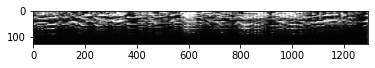

Epoch no 7501
Epoch no 7502
Epoch no 7503
Epoch no 7504
Epoch no 7505
Epoch no 7506
Epoch no 7507
Epoch no 7508
Epoch no 7509
Epoch no 7510
Epoch no 7511
Epoch no 7512
Epoch no 7513
Epoch no 7514
Epoch no 7515
Epoch no 7516
Epoch no 7517
Epoch no 7518
Epoch no 7519
Epoch no 7520
Epoch no 7521
Epoch no 7522
Epoch no 7523
Epoch no 7524
Epoch no 7525
Epoch no 7526
Epoch no 7527
Epoch no 7528
Epoch no 7529
Epoch no 7530
Epoch no 7531
Epoch no 7532
Epoch no 7533
Epoch no 7534
Epoch no 7535
Epoch no 7536
Epoch no 7537
Epoch no 7538
Epoch no 7539
Epoch no 7540
Epoch no 7541
Epoch no 7542
Epoch no 7543
Epoch no 7544
Epoch no 7545
Epoch no 7546
Epoch no 7547
Epoch no 7548
Epoch no 7549
Epoch no 7550
Epoch no 7551
Epoch no 7552
Epoch no 7553
Epoch no 7554
Epoch no 7555
Epoch no 7556
Epoch no 7557
Epoch no 7558
Epoch no 7559
Epoch no 7560
Epoch no 7561
Epoch no 7562
Epoch no 7563
Epoch no 7564
Epoch no 7565
Epoch no 7566
Epoch no 7567
Epoch no 7568
Epoch no 7569
Epoch no 7570
Epoch no 7571
Epoch 

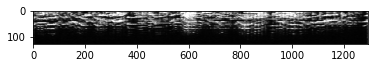

Epoch no 7751
Epoch no 7752
Epoch no 7753
Epoch no 7754
Epoch no 7755
Epoch no 7756
Epoch no 7757
Epoch no 7758
Epoch no 7759
Epoch no 7760
Epoch no 7761
Epoch no 7762
Epoch no 7763
Epoch no 7764
Epoch no 7765
Epoch no 7766
Epoch no 7767
Epoch no 7768
Epoch no 7769
Epoch no 7770
Epoch no 7771
Epoch no 7772
Epoch no 7773
Epoch no 7774
Epoch no 7775
Epoch no 7776
Epoch no 7777
Epoch no 7778
Epoch no 7779
Epoch no 7780
Epoch no 7781
Epoch no 7782
Epoch no 7783
Epoch no 7784
Epoch no 7785
Epoch no 7786
Epoch no 7787
Epoch no 7788
Epoch no 7789
Epoch no 7790
Epoch no 7791
Epoch no 7792
Epoch no 7793
Epoch no 7794
Epoch no 7795
Epoch no 7796
Epoch no 7797
Epoch no 7798
Epoch no 7799
Epoch no 7800
Epoch no 7801
Epoch no 7802
Epoch no 7803
Epoch no 7804
Epoch no 7805
Epoch no 7806
Epoch no 7807
Epoch no 7808
Epoch no 7809
Epoch no 7810
Epoch no 7811
Epoch no 7812
Epoch no 7813
Epoch no 7814
Epoch no 7815
Epoch no 7816
Epoch no 7817
Epoch no 7818
Epoch no 7819
Epoch no 7820
Epoch no 7821
Epoch 

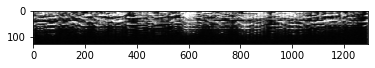

Epoch no 8001
Epoch no 8002
Epoch no 8003
Epoch no 8004
Epoch no 8005
Epoch no 8006
Epoch no 8007
Epoch no 8008
Epoch no 8009
Epoch no 8010
Epoch no 8011
Epoch no 8012
Epoch no 8013
Epoch no 8014
Epoch no 8015
Epoch no 8016
Epoch no 8017
Epoch no 8018
Epoch no 8019
Epoch no 8020
Epoch no 8021
Epoch no 8022
Epoch no 8023
Epoch no 8024
Epoch no 8025
Epoch no 8026
Epoch no 8027
Epoch no 8028
Epoch no 8029
Epoch no 8030
Epoch no 8031
Epoch no 8032
Epoch no 8033
Epoch no 8034
Epoch no 8035
Epoch no 8036
Epoch no 8037
Epoch no 8038
Epoch no 8039
Epoch no 8040
Epoch no 8041
Epoch no 8042
Epoch no 8043
Epoch no 8044
Epoch no 8045
Epoch no 8046
Epoch no 8047
Epoch no 8048
Epoch no 8049
Epoch no 8050
Epoch no 8051
Epoch no 8052
Epoch no 8053
Epoch no 8054
Epoch no 8055
Epoch no 8056
Epoch no 8057
Epoch no 8058
Epoch no 8059
Epoch no 8060
Epoch no 8061
Epoch no 8062
Epoch no 8063
Epoch no 8064
Epoch no 8065
Epoch no 8066
Epoch no 8067
Epoch no 8068
Epoch no 8069
Epoch no 8070
Epoch no 8071
Epoch 

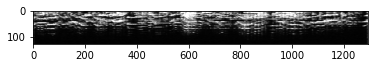

Epoch no 8251
Epoch no 8252
Epoch no 8253
Epoch no 8254
Epoch no 8255
Epoch no 8256
Epoch no 8257
Epoch no 8258
Epoch no 8259
Epoch no 8260
Epoch no 8261
Epoch no 8262
Epoch no 8263
Epoch no 8264
Epoch no 8265
Epoch no 8266
Epoch no 8267
Epoch no 8268
Epoch no 8269
Epoch no 8270
Epoch no 8271
Epoch no 8272
Epoch no 8273
Epoch no 8274
Epoch no 8275
Epoch no 8276
Epoch no 8277
Epoch no 8278
Epoch no 8279
Epoch no 8280
Epoch no 8281
Epoch no 8282
Epoch no 8283
Epoch no 8284
Epoch no 8285
Epoch no 8286
Epoch no 8287
Epoch no 8288
Epoch no 8289
Epoch no 8290
Epoch no 8291
Epoch no 8292
Epoch no 8293
Epoch no 8294
Epoch no 8295
Epoch no 8296
Epoch no 8297
Epoch no 8298
Epoch no 8299
Epoch no 8300
Epoch no 8301
Epoch no 8302
Epoch no 8303
Epoch no 8304
Epoch no 8305
Epoch no 8306
Epoch no 8307
Epoch no 8308
Epoch no 8309
Epoch no 8310
Epoch no 8311
Epoch no 8312
Epoch no 8313
Epoch no 8314
Epoch no 8315
Epoch no 8316
Epoch no 8317
Epoch no 8318
Epoch no 8319
Epoch no 8320
Epoch no 8321
Epoch 

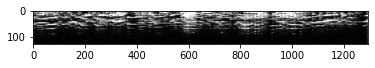

Epoch no 8501
Epoch no 8502
Epoch no 8503
Epoch no 8504
Epoch no 8505
Epoch no 8506
Epoch no 8507
Epoch no 8508
Epoch no 8509
Epoch no 8510
Epoch no 8511
Epoch no 8512
Epoch no 8513
Epoch no 8514
Epoch no 8515
Epoch no 8516
Epoch no 8517
Epoch no 8518
Epoch no 8519
Epoch no 8520
Epoch no 8521
Epoch no 8522
Epoch no 8523
Epoch no 8524
Epoch no 8525
Epoch no 8526
Epoch no 8527
Epoch no 8528
Epoch no 8529
Epoch no 8530
Epoch no 8531
Epoch no 8532
Epoch no 8533
Epoch no 8534
Epoch no 8535
Epoch no 8536
Epoch no 8537
Epoch no 8538
Epoch no 8539
Epoch no 8540
Epoch no 8541
Epoch no 8542
Epoch no 8543
Epoch no 8544
Epoch no 8545
Epoch no 8546
Epoch no 8547
Epoch no 8548
Epoch no 8549
Epoch no 8550
Epoch no 8551
Epoch no 8552
Epoch no 8553
Epoch no 8554
Epoch no 8555
Epoch no 8556
Epoch no 8557
Epoch no 8558
Epoch no 8559
Epoch no 8560
Epoch no 8561
Epoch no 8562
Epoch no 8563
Epoch no 8564
Epoch no 8565
Epoch no 8566
Epoch no 8567
Epoch no 8568
Epoch no 8569
Epoch no 8570
Epoch no 8571
Epoch 

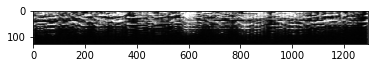

Epoch no 8751
Epoch no 8752
Epoch no 8753
Epoch no 8754
Epoch no 8755
Epoch no 8756
Epoch no 8757
Epoch no 8758
Epoch no 8759
Epoch no 8760
Epoch no 8761
Epoch no 8762
Epoch no 8763
Epoch no 8764
Epoch no 8765
Epoch no 8766
Epoch no 8767
Epoch no 8768
Epoch no 8769
Epoch no 8770
Epoch no 8771
Epoch no 8772
Epoch no 8773
Epoch no 8774
Epoch no 8775
Epoch no 8776
Epoch no 8777
Epoch no 8778
Epoch no 8779
Epoch no 8780
Epoch no 8781
Epoch no 8782
Epoch no 8783
Epoch no 8784
Epoch no 8785
Epoch no 8786
Epoch no 8787
Epoch no 8788
Epoch no 8789
Epoch no 8790
Epoch no 8791
Epoch no 8792
Epoch no 8793
Epoch no 8794
Epoch no 8795
Epoch no 8796
Epoch no 8797
Epoch no 8798
Epoch no 8799
Epoch no 8800
Epoch no 8801
Epoch no 8802
Epoch no 8803
Epoch no 8804
Epoch no 8805
Epoch no 8806
Epoch no 8807
Epoch no 8808
Epoch no 8809
Epoch no 8810
Epoch no 8811
Epoch no 8812
Epoch no 8813
Epoch no 8814
Epoch no 8815
Epoch no 8816
Epoch no 8817
Epoch no 8818
Epoch no 8819
Epoch no 8820
Epoch no 8821
Epoch 

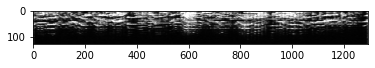

Epoch no 9001
Epoch no 9002
Epoch no 9003
Epoch no 9004
Epoch no 9005
Epoch no 9006
Epoch no 9007
Epoch no 9008
Epoch no 9009
Epoch no 9010
Epoch no 9011
Epoch no 9012
Epoch no 9013
Epoch no 9014
Epoch no 9015
Epoch no 9016
Epoch no 9017
Epoch no 9018
Epoch no 9019
Epoch no 9020
Epoch no 9021
Epoch no 9022
Epoch no 9023
Epoch no 9024
Epoch no 9025
Epoch no 9026
Epoch no 9027
Epoch no 9028
Epoch no 9029
Epoch no 9030
Epoch no 9031
Epoch no 9032
Epoch no 9033
Epoch no 9034
Epoch no 9035
Epoch no 9036
Epoch no 9037
Epoch no 9038
Epoch no 9039
Epoch no 9040
Epoch no 9041
Epoch no 9042
Epoch no 9043
Epoch no 9044
Epoch no 9045
Epoch no 9046
Epoch no 9047
Epoch no 9048
Epoch no 9049
Epoch no 9050
Epoch no 9051
Epoch no 9052
Epoch no 9053
Epoch no 9054
Epoch no 9055
Epoch no 9056
Epoch no 9057
Epoch no 9058
Epoch no 9059
Epoch no 9060
Epoch no 9061
Epoch no 9062
Epoch no 9063
Epoch no 9064
Epoch no 9065
Epoch no 9066
Epoch no 9067
Epoch no 9068
Epoch no 9069
Epoch no 9070
Epoch no 9071
Epoch 

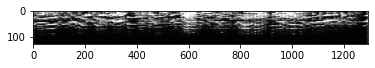

Epoch no 9251
Epoch no 9252
Epoch no 9253
Epoch no 9254
Epoch no 9255
Epoch no 9256
Epoch no 9257
Epoch no 9258
Epoch no 9259
Epoch no 9260
Epoch no 9261
Epoch no 9262
Epoch no 9263
Epoch no 9264
Epoch no 9265
Epoch no 9266
Epoch no 9267
Epoch no 9268
Epoch no 9269
Epoch no 9270
Epoch no 9271
Epoch no 9272
Epoch no 9273
Epoch no 9274
Epoch no 9275
Epoch no 9276
Epoch no 9277
Epoch no 9278
Epoch no 9279
Epoch no 9280
Epoch no 9281
Epoch no 9282
Epoch no 9283
Epoch no 9284
Epoch no 9285
Epoch no 9286
Epoch no 9287
Epoch no 9288
Epoch no 9289
Epoch no 9290
Epoch no 9291
Epoch no 9292
Epoch no 9293
Epoch no 9294
Epoch no 9295
Epoch no 9296
Epoch no 9297
Epoch no 9298
Epoch no 9299
Epoch no 9300
Epoch no 9301
Epoch no 9302
Epoch no 9303
Epoch no 9304
Epoch no 9305
Epoch no 9306
Epoch no 9307
Epoch no 9308
Epoch no 9309
Epoch no 9310
Epoch no 9311
Epoch no 9312
Epoch no 9313
Epoch no 9314
Epoch no 9315
Epoch no 9316
Epoch no 9317
Epoch no 9318
Epoch no 9319
Epoch no 9320
Epoch no 9321
Epoch 

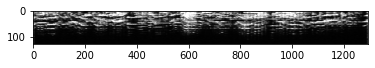

Epoch no 9501
Epoch no 9502
Epoch no 9503
Epoch no 9504
Epoch no 9505
Epoch no 9506
Epoch no 9507
Epoch no 9508
Epoch no 9509
Epoch no 9510
Epoch no 9511
Epoch no 9512
Epoch no 9513
Epoch no 9514
Epoch no 9515
Epoch no 9516
Epoch no 9517
Epoch no 9518
Epoch no 9519
Epoch no 9520
Epoch no 9521
Epoch no 9522
Epoch no 9523
Epoch no 9524
Epoch no 9525
Epoch no 9526
Epoch no 9527
Epoch no 9528
Epoch no 9529
Epoch no 9530
Epoch no 9531
Epoch no 9532
Epoch no 9533
Epoch no 9534
Epoch no 9535
Epoch no 9536
Epoch no 9537
Epoch no 9538
Epoch no 9539
Epoch no 9540
Epoch no 9541
Epoch no 9542
Epoch no 9543
Epoch no 9544
Epoch no 9545
Epoch no 9546
Epoch no 9547
Epoch no 9548
Epoch no 9549
Epoch no 9550
Epoch no 9551
Epoch no 9552
Epoch no 9553
Epoch no 9554
Epoch no 9555
Epoch no 9556
Epoch no 9557
Epoch no 9558
Epoch no 9559
Epoch no 9560
Epoch no 9561
Epoch no 9562
Epoch no 9563
Epoch no 9564
Epoch no 9565
Epoch no 9566
Epoch no 9567
Epoch no 9568
Epoch no 9569
Epoch no 9570
Epoch no 9571
Epoch 

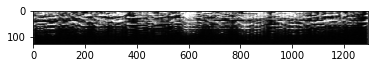

Epoch no 9751
Epoch no 9752
Epoch no 9753
Epoch no 9754
Epoch no 9755
Epoch no 9756
Epoch no 9757
Epoch no 9758
Epoch no 9759
Epoch no 9760
Epoch no 9761
Epoch no 9762
Epoch no 9763
Epoch no 9764
Epoch no 9765
Epoch no 9766
Epoch no 9767
Epoch no 9768
Epoch no 9769
Epoch no 9770
Epoch no 9771
Epoch no 9772
Epoch no 9773
Epoch no 9774
Epoch no 9775
Epoch no 9776
Epoch no 9777
Epoch no 9778
Epoch no 9779
Epoch no 9780
Epoch no 9781
Epoch no 9782
Epoch no 9783
Epoch no 9784
Epoch no 9785
Epoch no 9786
Epoch no 9787
Epoch no 9788
Epoch no 9789
Epoch no 9790
Epoch no 9791
Epoch no 9792
Epoch no 9793
Epoch no 9794
Epoch no 9795
Epoch no 9796
Epoch no 9797
Epoch no 9798
Epoch no 9799
Epoch no 9800
Epoch no 9801
Epoch no 9802
Epoch no 9803
Epoch no 9804
Epoch no 9805
Epoch no 9806
Epoch no 9807
Epoch no 9808
Epoch no 9809
Epoch no 9810
Epoch no 9811
Epoch no 9812
Epoch no 9813
Epoch no 9814
Epoch no 9815
Epoch no 9816
Epoch no 9817
Epoch no 9818
Epoch no 9819
Epoch no 9820
Epoch no 9821
Epoch 

In [26]:
generated_image = tf.Variable(generated_image)
print(generated_image.shape)

epochs = 10000
for i in range(epochs):
  print(f"Epoch no {i}")
  train_step(generated_image)
  if i % 250 == 0:
    image = tensor_to_image(generated_image)
    imshow(image)
    image.save(f"/content/drive/MyDrive/CS308/output_image/image_{i}.tiff")
    plt.show() 

In [27]:
generated_file_path = ""
mel_to_wav("/content/drive/MyDrive/CS308/output_image/image_9750.tiff", content_sampeling_rate)

[[151. 225. 255. ...  78.  61.  88.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 189.]
 ...
 [ 23.  44.  46. ...  59.  48.  26.]
 [ 86.  75.  65. ...   0.   0.   0.]
 [ 37.  52.  50. ...  52.  46.  70.]]
